<a href="https://colab.research.google.com/github/adliaulia/Cityscape-image-segmentation/blob/main/Cityscape-semantic-segmentation_Adli-Aulia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project 3: Self Driving Car**
# **Indonesia AI - Computer Vision **</br>
->Muhammad Muzakky Al Maududy

Dataset: Cityscapes Dataset</br>
The data contains in the form of
1.   Images
2.   Annotations

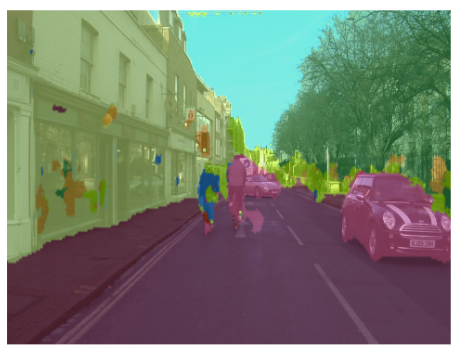

**11 Labels of the annotation**

0 = background
1.   Sky
2.   Building
3.   Pole
4.   Road
5.   Pavement
6.   Tree
7.   SignSymbol
8.   Fence
9.   Car
10.   Pedestrian
11.   Bicyclist


In [22]:
# pip install opencv-python

In [23]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
from tensorflow.keras.preprocessing.image import load_img
import random
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.optimizers import Adam

# from google.colab.patches import cv2_imshow
import glob

In [24]:
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPU Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.8.0
/device:GPU:0
Num GPU Available:  1


2023-08-26 00:12:37.726829: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 38184 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0


# Acquisition Dataset

## ImportImages & Annotations

In [25]:
# Specify the path to your local drive
LOCAL_PATH = '/home/jovyan/Cityscape-image-segmentation-main/'

# List the contents of the specified path
import os
contents = os.listdir(LOCAL_PATH)
for item in contents:
    print(item)


5 Unet Cityscape-semantic-segmentation.ipynb
Cityscape-semantic-segmentation.ipynb
1-my_model-10.h5
U-NET-Cityscape-semantic-segmentation.ipynb
3 Unet Cityscape-semantic-segmentation .ipynb
Dataset
README.md
model
Course Indonesia AI - CV
4 Unet Cityscape-semantic-segmentation.ipynb
TEST.txt
2 Unet Cityscape-semantic-segmentation (1).ipynb
TEST2.txt
3 FCN Cityscape-semantic-segmentation.ipynb
my_model-15.h5
9 Unet Cityscape-semantic-segmentation.ipynb
2 FCN Cityscape-semantic-segmentation copy.ipynb
Prediction image
samuel.ipynb
7 Unet Cityscape-semantic-segmentation.ipynb
6 Unet Cityscape-semantic-segmentation.ipynb
Dataset2
Cityscape-semantic-segmentation-3.ipynb
FCN Cityscape-semantic-segmentation.ipynb
Cityscape-semantic-segmentation_2.ipynb
8 Unet Cityscape-semantic-segmentation.ipynb


In [26]:
IMAGES_X_TRAIN_PATH = "Dataset/images_prepped_train/" #dir_x, # 367 images
IMAGES_X_TEST_PATH = "Dataset/images_prepped_test/"

IMAGES_Y_TRAIN_PATH = "Dataset/annotations_prepped_train/" #dir_y, # 101 images
IMAGES_Y_TEST_PATH = "Dataset/annotations_prepped_test/" 

images_train_filename = os.listdir(os.path.join(LOCAL_PATH, IMAGES_X_TRAIN_PATH))
images_test_filename = os.listdir(os.path.join(LOCAL_PATH, IMAGES_X_TEST_PATH))

In [27]:
print(images_train_filename)
print(images_test_filename)

['0016E5_06210.png', '0016E5_06900.png', '0016E5_07530.png', '0016E5_07740(2).png', '0001TP_007800.png', '0001TP_007500.png', '0016E5_01590.png', '0016E5_06330.png', '0001TP_008280.png', '0016E5_00570.png', '0016E5_05310.png', '0016E5_07650(1).png', '0006R0_f02010.png', '0006R0_f02160.png', '0016E5_02040.png', '0006R0_f00930.png', '0006R0_f01170.png', '0006R0_f02880.png', '0016E5_07110.png', '0001TP_008070.png', '0006R0_f01590.png', '0016E5_05760.png', '0016E5_04620.png', '0016E5_02340.png', '0001TP_007110.png', '0016E5_07740(1).png', '0016E5_05160.png', '0006R0_f02550.png', '0006R0_f01290.png', '0016E5_06780.png', '0016E5_05970.png', '0001TP_006870.png', '0006R0_f02520.png', '0006R0_f03840(1).png', '0016E5_07470.png', '0016E5_05400.png', '0016E5_07710(1).png', '0006R0_f02610.png', '0006R0_f03810(1).png', '0001TP_007140.png', '0016E5_06360.png', '0016E5_00720.png', '0016E5_07770(2).png', '0016E5_07230.png', '0016E5_07650(2).png', '0016E5_01140.png', '0006R0_f02910.png', '0006R0_f01800.

## Load the Dataset

In [28]:
def preprocess_data(filename, dir_x, dir_y, SHAPE = 416):
  # cv2.imread(path, flag). Using 0 to read image in grayscale mode
  image_x = cv2.imread(dir_x + filename, 0)
  image_y = cv2.imread(dir_y + filename, 0)

  if image_y is None:
    print(f"Error: image {filename} not found or corrupted")
    return None, None

  #reshaping image to 224x224
  image_x = cv2.resize(image_x, (SHAPE, SHAPE), interpolation=cv2.INTER_NEAREST)
  image_y = cv2.resize(image_y, (SHAPE, SHAPE), interpolation=cv2.INTER_NEAREST)

  return image_x, image_y

In [29]:
IMAGES_TRAIN_ARR = []
ANNOTATIONS_TRAIN_ARR = []
IMAGES_TEST_ARR = []
ANNOTATIONS_TEST_ARR = []

for filename in images_train_filename:
  img_x, img_y = preprocess_data(filename, os.path.join(LOCAL_PATH, IMAGES_X_TRAIN_PATH), os.path.join(LOCAL_PATH, IMAGES_Y_TRAIN_PATH), 416)

  #checking if img_x and img_y are not None
  if img_x is not None and img_y is not None:
    IMAGES_TRAIN_ARR.append(img_x)
    ANNOTATIONS_TRAIN_ARR.append(img_y)

for filename in images_test_filename:
  img_x, img_y = preprocess_data(filename, os.path.join(LOCAL_PATH, IMAGES_X_TEST_PATH), os.path.join(LOCAL_PATH, IMAGES_Y_TEST_PATH), 416)
  IMAGES_TEST_ARR.append(img_x)
  ANNOTATIONS_TEST_ARR.append(img_y)

IMAGES_TRAIN_ARR = np.array(IMAGES_TRAIN_ARR)
ANNOTATIONS_TRAIN_ARR = np.array(ANNOTATIONS_TRAIN_ARR)
IMAGES_TEST_ARR = np.array(IMAGES_TEST_ARR)
ANNOTATIONS_TEST_ARR = np.array(ANNOTATIONS_TEST_ARR)

Error: image 0016E5_07740(2).png not found or corrupted
Error: image 0016E5_07650(1).png not found or corrupted
Error: image 0016E5_07740(1).png not found or corrupted


[ WARN:0@67.384] global loadsave.cpp:248 findDecoder imread_('/home/jovyan/Cityscape-image-segmentation-main/Dataset/annotations_prepped_train/0016E5_07740(2).png'): can't open/read file: check file path/integrity
[ WARN:0@67.442] global loadsave.cpp:248 findDecoder imread_('/home/jovyan/Cityscape-image-segmentation-main/Dataset/annotations_prepped_train/0016E5_07650(1).png'): can't open/read file: check file path/integrity
[ WARN:0@67.537] global loadsave.cpp:248 findDecoder imread_('/home/jovyan/Cityscape-image-segmentation-main/Dataset/annotations_prepped_train/0016E5_07740(1).png'): can't open/read file: check file path/integrity


Error: image 0006R0_f03840(1).png not found or corrupted
Error: image 0016E5_07710(1).png not found or corrupted
Error: image 0006R0_f03810(1).png not found or corrupted
Error: image 0016E5_07770(2).png not found or corrupted
Error: image 0016E5_07650(2).png not found or corrupted
Error: image 0006R0_f03930(1).png not found or corrupted


[ WARN:0@67.592] global loadsave.cpp:248 findDecoder imread_('/home/jovyan/Cityscape-image-segmentation-main/Dataset/annotations_prepped_train/0006R0_f03840(1).png'): can't open/read file: check file path/integrity
[ WARN:0@67.612] global loadsave.cpp:248 findDecoder imread_('/home/jovyan/Cityscape-image-segmentation-main/Dataset/annotations_prepped_train/0016E5_07710(1).png'): can't open/read file: check file path/integrity
[ WARN:0@67.624] global loadsave.cpp:248 findDecoder imread_('/home/jovyan/Cityscape-image-segmentation-main/Dataset/annotations_prepped_train/0006R0_f03810(1).png'): can't open/read file: check file path/integrity
[ WARN:0@67.651] global loadsave.cpp:248 findDecoder imread_('/home/jovyan/Cityscape-image-segmentation-main/Dataset/annotations_prepped_train/0016E5_07770(2).png'): can't open/read file: check file path/integrity
[ WARN:0@67.664] global loadsave.cpp:248 findDecoder imread_('/home/jovyan/Cityscape-image-segmentation-main/Dataset/annotations_prepped_train

Error: image 0016E5_07860(2).png not found or corrupted
Error: image 0016E5_07920(2).png not found or corrupted


[ WARN:0@67.800] global loadsave.cpp:248 findDecoder imread_('/home/jovyan/Cityscape-image-segmentation-main/Dataset/annotations_prepped_train/0016E5_07860(2).png'): can't open/read file: check file path/integrity
[ WARN:0@67.990] global loadsave.cpp:248 findDecoder imread_('/home/jovyan/Cityscape-image-segmentation-main/Dataset/annotations_prepped_train/0016E5_07920(2).png'): can't open/read file: check file path/integrity


Error: image 0016E5_07680(2).png not found or corrupted
Error: image 0006R0_f03750(1).png not found or corrupted
Error: image 0016E5_07830(1).png not found or corrupted
Error: image 0016E5_07620(1).png not found or corrupted
Error: image 0016E5_07800(1).png not found or corrupted
Error: image 0016E5_05400(1).png not found or corrupted
Error: image 0016E5_07770(1).png not found or corrupted


[ WARN:0@68.140] global loadsave.cpp:248 findDecoder imread_('/home/jovyan/Cityscape-image-segmentation-main/Dataset/annotations_prepped_train/0016E5_07680(2).png'): can't open/read file: check file path/integrity
[ WARN:0@68.208] global loadsave.cpp:248 findDecoder imread_('/home/jovyan/Cityscape-image-segmentation-main/Dataset/annotations_prepped_train/0006R0_f03750(1).png'): can't open/read file: check file path/integrity
[ WARN:0@68.214] global loadsave.cpp:248 findDecoder imread_('/home/jovyan/Cityscape-image-segmentation-main/Dataset/annotations_prepped_train/0016E5_07830(1).png'): can't open/read file: check file path/integrity
[ WARN:0@68.247] global loadsave.cpp:248 findDecoder imread_('/home/jovyan/Cityscape-image-segmentation-main/Dataset/annotations_prepped_train/0016E5_07620(1).png'): can't open/read file: check file path/integrity
[ WARN:0@68.267] global loadsave.cpp:248 findDecoder imread_('/home/jovyan/Cityscape-image-segmentation-main/Dataset/annotations_prepped_train/

Error: image 0016E5_07710(2).png not found or corrupted
Error: image 0006R0_f03720(1).png not found or corrupted
Error: image 0006R0_f03630(1).png not found or corrupted
Error: image 0016E5_07920(1).png not found or corrupted


[ WARN:0@68.468] global loadsave.cpp:248 findDecoder imread_('/home/jovyan/Cityscape-image-segmentation-main/Dataset/annotations_prepped_train/0016E5_07710(2).png'): can't open/read file: check file path/integrity
[ WARN:0@68.522] global loadsave.cpp:248 findDecoder imread_('/home/jovyan/Cityscape-image-segmentation-main/Dataset/annotations_prepped_train/0006R0_f03720(1).png'): can't open/read file: check file path/integrity
[ WARN:0@68.542] global loadsave.cpp:248 findDecoder imread_('/home/jovyan/Cityscape-image-segmentation-main/Dataset/annotations_prepped_train/0006R0_f03630(1).png'): can't open/read file: check file path/integrity
[ WARN:0@68.571] global loadsave.cpp:248 findDecoder imread_('/home/jovyan/Cityscape-image-segmentation-main/Dataset/annotations_prepped_train/0016E5_07920(1).png'): can't open/read file: check file path/integrity


Error: image 0016E5_07620(2).png not found or corrupted
Error: image 0006R0_f03780(1).png not found or corrupted
Error: image 0016E5_07800(2).png not found or corrupted
Error: image 0016E5_07830(2).png not found or corrupted


[ WARN:0@68.707] global loadsave.cpp:248 findDecoder imread_('/home/jovyan/Cityscape-image-segmentation-main/Dataset/annotations_prepped_train/0016E5_07620(2).png'): can't open/read file: check file path/integrity
[ WARN:0@68.763] global loadsave.cpp:248 findDecoder imread_('/home/jovyan/Cityscape-image-segmentation-main/Dataset/annotations_prepped_train/0006R0_f03780(1).png'): can't open/read file: check file path/integrity
[ WARN:0@68.783] global loadsave.cpp:248 findDecoder imread_('/home/jovyan/Cityscape-image-segmentation-main/Dataset/annotations_prepped_train/0016E5_07800(2).png'): can't open/read file: check file path/integrity
[ WARN:0@68.810] global loadsave.cpp:248 findDecoder imread_('/home/jovyan/Cityscape-image-segmentation-main/Dataset/annotations_prepped_train/0016E5_07830(2).png'): can't open/read file: check file path/integrity


Error: image 0006R0_f03690(1).png not found or corrupted
Error: image 0006R0_f03660(1).png not found or corrupted


[ WARN:0@68.921] global loadsave.cpp:248 findDecoder imread_('/home/jovyan/Cityscape-image-segmentation-main/Dataset/annotations_prepped_train/0006R0_f03690(1).png'): can't open/read file: check file path/integrity
[ WARN:0@69.060] global loadsave.cpp:248 findDecoder imread_('/home/jovyan/Cityscape-image-segmentation-main/Dataset/annotations_prepped_train/0006R0_f03660(1).png'): can't open/read file: check file path/integrity


Error: image 0006R0_f03600(1).png not found or corrupted
Error: image 0016E5_07680(1).png not found or corrupted


[ WARN:0@69.225] global loadsave.cpp:248 findDecoder imread_('/home/jovyan/Cityscape-image-segmentation-main/Dataset/annotations_prepped_train/0006R0_f03600(1).png'): can't open/read file: check file path/integrity
[ WARN:0@69.417] global loadsave.cpp:248 findDecoder imread_('/home/jovyan/Cityscape-image-segmentation-main/Dataset/annotations_prepped_train/0016E5_07680(1).png'): can't open/read file: check file path/integrity


Error: image 0016E5_07860(1).png not found or corrupted


[ WARN:0@69.430] global loadsave.cpp:248 findDecoder imread_('/home/jovyan/Cityscape-image-segmentation-main/Dataset/annotations_prepped_train/0016E5_07860(1).png'): can't open/read file: check file path/integrity


In [30]:
print('IMAGES TRAIN ARRAY SHAPE:', IMAGES_TRAIN_ARR.shape)
print('ANNOTA TRAIN ARRAY SHAPE:', ANNOTATIONS_TRAIN_ARR.shape)
print('IMAGES TEST ARRAY SHAPE:', IMAGES_TEST_ARR.shape)
print('ANNOTA TEST ARRAY SHAPE:', ANNOTATIONS_TEST_ARR.shape)

IMAGES TRAIN ARRAY SHAPE: (367, 416, 416)
ANNOTA TRAIN ARRAY SHAPE: (367, 416, 416)
IMAGES TEST ARRAY SHAPE: (101, 416, 416)
ANNOTA TEST ARRAY SHAPE: (101, 416, 416)


# Data Preprocessing

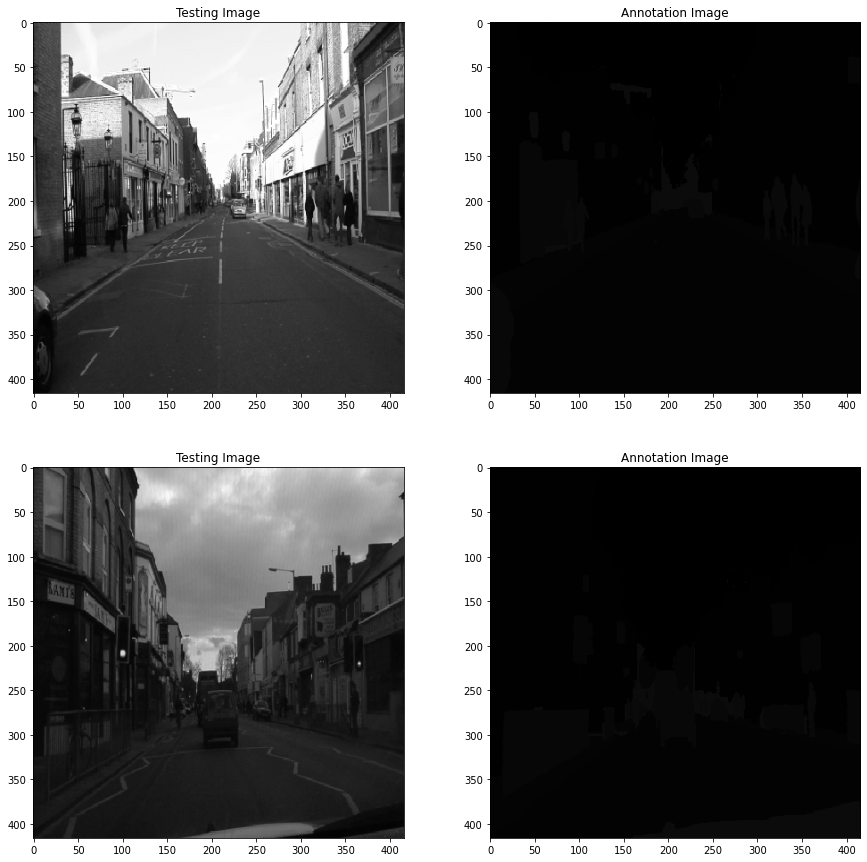

In [31]:
# plot training images
plt.figure(figsize=(15,15))
for i in range(1, 4, 2):
  plt.subplot(2, 2, i)
  plt.imshow(IMAGES_TRAIN_ARR[i], cmap='gray', vmin=0, vmax=255)
  plt.title('Testing Image')
  plt.subplot(2, 2, i+1)
  plt.imshow(ANNOTATIONS_TRAIN_ARR[i], cmap='gray', vmin=0, vmax=255)
  plt.title('Annotation Image')
plt.show()

In [32]:
# function to get unique values
def get_class(image_y):
  array = image_y.ravel()
  return np.unique(array)

In [33]:
# get information from the dataset
print('image prepped train shape:', IMAGES_TRAIN_ARR.shape)
print('annotations prepped train shape:', ANNOTATIONS_TRAIN_ARR.shape)
print('image prepped test shape:', IMAGES_TEST_ARR.shape)
print('annotations prepped test shape:', ANNOTATIONS_TEST_ARR.shape)
print('data train:', len(IMAGES_TRAIN_ARR))
print('data test:', len(IMAGES_TEST_ARR))

print('\n')
print("unique value of 'annotation'")
print("kind of class :", get_class(ANNOTATIONS_TRAIN_ARR[2]))
print("number of classes:", len(get_class(ANNOTATIONS_TRAIN_ARR[2])))

print('\n')
print("unique value of 'image'")
print("kind of class :\n", get_class(IMAGES_TRAIN_ARR[2]))
print("number of classes:", len(get_class(IMAGES_TRAIN_ARR[2])))

image prepped train shape: (367, 416, 416)
annotations prepped train shape: (367, 416, 416)
image prepped test shape: (101, 416, 416)
annotations prepped test shape: (101, 416, 416)
data train: 367
data test: 101


unique value of 'annotation'
kind of class : [ 0  1  2  3  4  5  6  7  8  9 10 11]
number of classes: 12


unique value of 'image'
kind of class :
 [  3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 

## Normalize Data

In [34]:
# Data train
x = np.expand_dims(IMAGES_TRAIN_ARR, axis=3)
train_x_norm = normalize(x.reshape(x.shape[0],-1), axis=1).reshape(x.shape)
train_y_norm = np.expand_dims(ANNOTATIONS_TRAIN_ARR, axis=3)

# # Data test
y = np.expand_dims(IMAGES_TEST_ARR, axis=3)
test_x_norm = normalize(y.reshape(y.shape[0],-1), axis=1).reshape(y.shape)
test_y_norm = np.expand_dims(ANNOTATIONS_TEST_ARR, axis=3)

In [35]:
# after normalization data
print('Train images shape:', train_x_norm.shape)
print('Train annots shape:', train_y_norm.shape)
print('Test images shape:', test_x_norm.shape)
print('Test annots shape:', test_y_norm.shape)

Train images shape: (367, 416, 416, 1)
Train annots shape: (367, 416, 416, 1)
Test images shape: (101, 416, 416, 1)
Test annots shape: (101, 416, 416, 1)


## Split Dataset

In [36]:
# split train data -> train & validation data 
train_x, val_x, train_y, val_y = train_test_split(train_x_norm, train_y_norm, test_size=0.1, random_state=14)
print('Train images shape:', train_x.shape)
print('Valid images shape:', val_x.shape)
print('Train annots shape:', train_y.shape)
print('Valid images shape:', val_y.shape)

# test = test_norm
test_x, test_y = test_x_norm, test_y_norm
print('Test annots shape:', test_x.shape)
print('Test images shape:', test_y.shape)

Train images shape: (330, 416, 416, 1)
Valid images shape: (37, 416, 416, 1)
Train annots shape: (330, 416, 416, 1)
Valid images shape: (37, 416, 416, 1)
Test annots shape: (101, 416, 416, 1)
Test images shape: (101, 416, 416, 1)


## Encode Annotations Dataset

In [37]:
# num of classes
n_classes = 12

# One Hot Encoding Train Data Annotation
train_y_cat = keras.utils.to_categorical(train_y, num_classes=n_classes)

# One Hot Encoding Val Data Annotation
val_y_cat = keras.utils.to_categorical(val_y, num_classes=n_classes)

# One Hot Encoding Test Data Annotation
test_y_cat = keras.utils.to_categorical(test_y_norm, num_classes=n_classes)

In [38]:
# after encode annotations dataset
print('Class values in the dataset are:', get_class(train_y[0]))
print('Train images shape', train_x.shape)
print('Train labels shape', train_y_cat.shape)

print('\nClass values in the dataset are:', get_class(val_y[0]))
print('Validation images shape', val_x.shape)
print('Validation labels shape', val_y_cat.shape)

print('\nClass values in the dataset are:', get_class(test_y[0]))
print('Test images shape', test_x.shape)
print('Test labels shape', test_y_cat.shape)

Class values in the dataset are: [ 0  1  2  3  5  6  8  9 11]
Train images shape (330, 416, 416, 1)
Train labels shape (330, 416, 416, 12)

Class values in the dataset are: [ 0  1  2  3  4  5  6  8  9 10 11]
Validation images shape (37, 416, 416, 1)
Validation labels shape (37, 416, 416, 12)

Class values in the dataset are: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Test images shape (101, 416, 416, 1)
Test labels shape (101, 416, 416, 12)


# Build the Model
Using FCN or UNet

In [39]:
#FCN Model

import tensorflow as tf

def FCN_model(len_classes=12, dropout_rate=0.2):

    # Input layer
    input = tf.keras.layers.Input(shape=(416, 416, 1), name='input')

    # A convolution block
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
  # Uncomment the below line if you're using dense layers
  # x = tf.keras.layers.GlobalMaxPooling2D()(x)

  # Fully connected layer 1
  # x = tf.keras.layers.Dropout(dropout_rate)(x)
  # x = tf.keras.layers.BatchNormalization()(x)
  # x = tf.keras.layers.Dense(units=64)(x)
  # x = tf.keras.layers.Activation('relu')(x)

  # Fully connected layer 1
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

# Fully connected layer 2
# x = tf.keras.layers.Dropout(dropout_rate)(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dense(units=len_classes)(x)
# predictions = tf.keras.layers.Activation('softmax')(x)

# Fully connected layer 2
    x = tf.keras.layers.Conv2D(filters=len_classes, kernel_size=3, strides=1, padding='same')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    #x = tf.keras.layers.GlobalMaxPooling2D()(x)
    predictions = tf.keras.layers.Activation('softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=predictions)
    #print(model.summary())
    return model

In [40]:
#Creating FCN Model
model = FCN_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 416, 416, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 416, 416, 64)      640       
                                                                 
 dropout_3 (Dropout)         (None, 416, 416, 64)      0         
                                                                 
 batch_normalization_3 (Batc  (None, 416, 416, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 416, 416, 64)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 416, 416, 64)      36928     
                                                           

In [41]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## Train the Model

In [42]:
# from re import VERBOSE
# Train training ke-
from datetime import datetime
import pytz

iter = 1
batch_size = 8
epoch = 100
learning_rate=0.001

# Define the timezone
tz = pytz.timezone('Asia/Jakarta')

# Get the current date and time in the specified timezone
now = datetime.now(tz)

# Format the time

now2 = now.strftime("%Y-%m-%d-%H-%M-%S")

# Display the formatted date and time
# print(now2)

# Checkpoint
MODEL_DIRECTORY = LOCAL_PATH + "model/"
MODEL_NAME = f'model6-iter-{iter}-batch-{batch_size}-epoch{epoch}-lr-{learning_rate}-no_ES-DnT-{now2}.h5'
MODEL_PATH = os.path.join(MODEL_DIRECTORY, MODEL_NAME)
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=MODEL_PATH, 
                                                            monitor='val_accuracy', 
                                                            mode='max', 
                                                            save_best_only=True)

# Early Stopping (ES)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', min_delta=0.0001, verbose = 1, restore_best_weights = True)

opt = Adam(learning_rate)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

# Train model
history = model.fit(train_x, train_y_cat, validation_data=(val_x, val_y_cat), epochs=epoch, batch_size=batch_size, callbacks=[model_checkpoint])

Epoch 1/100


2023-08-26 00:13:10.266711: I tensorflow/stream_executor/cuda/cuda_dnn.cc:379] Loaded cuDNN version 8400


42/42 [==============================] - 12s 77ms/step - loss: 2.2329 - accuracy: 0.2534 - val_loss: 2.4204 - val_accuracy: 0.3259
Epoch 2/100
42/42 [==============================] - 3s 63ms/step - loss: 2.0758 - accuracy: 0.3935 - val_loss: 2.3663 - val_accuracy: 0.3259
Epoch 3/100
42/42 [==============================] - 3s 60ms/step - loss: 1.9467 - accuracy: 0.4539 - val_loss: 2.3073 - val_accuracy: 0.3259
Epoch 4/100
42/42 [==============================] - 3s 60ms/step - loss: 1.8647 - accuracy: 0.4948 - val_loss: 2.2379 - val_accuracy: 0.3259
Epoch 5/100
42/42 [==============================] - 3s 60ms/step - loss: 1.8087 - accuracy: 0.5184 - val_loss: 2.1764 - val_accuracy: 0.3259
Epoch 6/100
42/42 [==============================] - 3s 74ms/step - loss: 1.7410 - accuracy: 0.5375 - val_loss: 2.1376 - val_accuracy: 0.3259
Epoch 7/100
42/42 [==============================] - 3s 69ms/step - loss: 1.6929 - accuracy: 0.5463 - val_loss: 2.1087 - val_accuracy: 0.3259
Epoch 8/100
42/42

## Plot Figure Training and Validation

In [52]:
print(now2)

2023-08-26-07-12-59


/tmp/ipykernel_1770788/1742680729.py:26: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))


saving figure to:


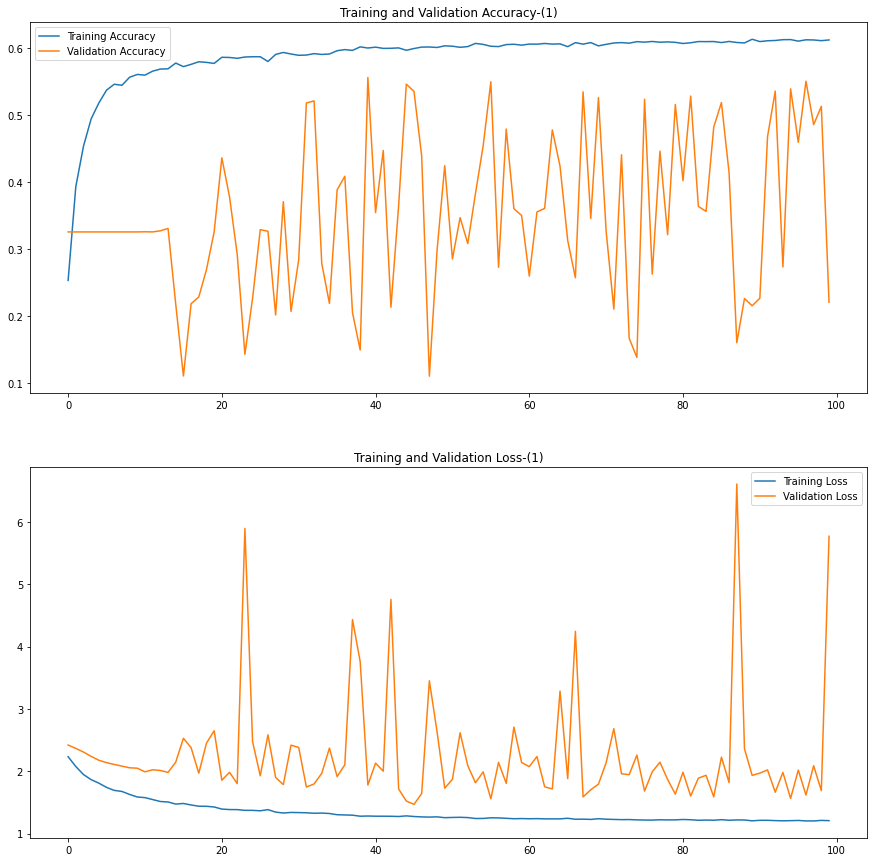

In [43]:
# Plot training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title(f'Training and Validation Accuracy-({iter})')

plt.subplot(2,1,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')

plt.title(f'Training and Validation Loss-({iter})')

# save figure
PATH_FIGURE = "/"
dir_name = os.path.join(LOCAL_PATH, PATH_FIGURE)
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
print('saving figure to:')
plt.savefig(f"Training and validation-{iter}.png")

plt.show()

## Save the Model Manually

In [44]:
# # saving the model manually

# MODEL_DIRECTORY = LOCAL_PATH 
# MODEL_NAME = f'my_model-{iter}.h5'
# MODEL_PATH = os.path.join(MODEL_DIRECTORY, MODEL_NAME)

# model.save(DIRECTORY_PATH)
# print('Saved trained model at %s ' % MODEL_PATH)
# saving the model manually

# MODEL_DIRECTORY = LOCAL_PATH + "model/"
# MODEL_NAME = f'model-iter-{iter}-batch-{batch_size}-epoch{epoch}-lr-{learning_rate}-no_ES-DnT-{now2}.h5'
# MODEL_PATH = os.path.join(MODEL_DIRECTORY, MODEL_NAME)

# model.save(MODEL_PATH)  # Use MODEL_PATH instead of DIRECTORY_PATH
# print('Saved trained model at %s ' % MODEL_PATH)


# Load the Model

In [45]:
# View the models stored in the model directory
MODEL_DIRECTORY = '/home/jovyan/Cityscape-image-segmentation-main/model'
MODEL_LISTDIR = os.listdir(MODEL_DIRECTORY)
MODEL_LISTDIR

['model-iter-4-batch-4-epoch300-lr-1e-06-no_ES-DnT-2023-08-25-11-02-36.h5',
 'model3-iter-4-batch-4-epoch300-lr-1e-06-no_ES-DnT-2023-08-25-11-02-36.h5',
 'model-iter-10-batch-16-epoch150-lr-0.001-no_ES-DnT-2023-08-25-09-38-49.h5',
 'model6-iter-1-batch-8-epoch100-lr-0.001-no_ES-DnT-2023-08-26-07-12-59.h5',
 'model7-iter-3-batch-16-epoch100-lr-0.001-no_ES-DnT-2023-08-25-15-40-46.h5',
 'model3-iter-10-batch-16-epoch300-lr-0.001-no_ES-DnT-2023-08-25-10-09-19.h5',
 'model6-iter-1-batch-8-epoch100-lr-0.001-no_ES-DnT-2023-08-25-21-37-28.h5',
 'model3-iter-3-batch-4-epoch300-lr-0.001-no_ES-DnT-2023-08-25-12-17-39.h5',
 'MODEL',
 'model6-iter-1-batch-4-epoch100-lr-0.001-no_ES-DnT-2023-08-25-16-10-15.h5',
 'model-iter-10-batch-16-epoch300-lr-0.001-no_ES-DnT-2023-08-25-10-09-19.h5',
 'model6-iter-1-batch-8-epoch100-lr-0.001-no_ES-DnT-2023-08-25-22-07-30.h5',
 'model-iter-10-batch-16-epoch150-lr-0.001-no_ES-DnT-2023-08-25-09-38-49.h5-',
 'model6-iter-3-batch-4-epoch100-lr-0.001-no_ES-DnT-2023-08-

In [46]:
# load the model and weight
LOADMODEL_PATH = os.path.join(MODEL_DIRECTORY, MODEL_NAME)
load_model = keras.models.load_model(LOADMODEL_PATH)
print('Loaded trained model at %s' %LOADMODEL_PATH)

Loaded trained model at /home/jovyan/Cityscape-image-segmentation-main/model/model6-iter-1-batch-8-epoch100-lr-0.001-no_ES-DnT-2023-08-26-07-12-59.h5


## Evaluate the Model

In [47]:
# Evaluate the model with the same amount of validation data
# test_x_norm[:37], test_y_cat[:37]
score = load_model.evaluate(test_x[:10], test_y_cat[:10], verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.950362205505371
Test accuracy: 0.5074646472930908


## Check the Model Prediction

In [48]:
import math

early_stopping

n_classes=12
# give color annota img
def give_color_to_annota_img(annota_img):
  random_colors = []

  for i in range(5000):
    random.seed(i)
    randColor = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    random_colors.append(randColor)

  annota_img_zeros = np.zeros((416, 416, 3))
  for j in range(n_classes):
    annota_img_zeros[:, :, 0] += ((annota_img[:, :, 0] == j)*(random_colors[j][0])).astype('uint8')
    annota_img_zeros[:, :, 1] += ((annota_img[:, :, 0] == j)*(random_colors[j][1])).astype('uint8')
    annota_img_zeros[:, :, 2] += ((annota_img[:, :, 0] == j)*(random_colors[j][2])).astype('uint8')

  annota_img_zeros = cv2.cvtColor(np.array(annota_img_zeros, dtype=np.uint8), cv2.COLOR_BGR2RGB)
  return annota_img_zeros

# plot grayscale img
def plot_img(input_img, title='', iter=0):
  N_ch = input_img.shape[2]
  if N_ch == 1:
    plt.imshow(input_img[:,:,0], cmap='gray', vmin=0, vmax=255)
    plt.title(title + f' {[iter]}')
  elif N_ch == 3:
    plt.imshow(input_img)
    plt.title(title + f' {[iter]}')
  else:
    print('error image')
    return
  # set the spacing between subplots
  plt.subplots_adjust(bottom=0.1, top=0.5)

# invert encoding (to_categorical) to original data
def invert_from_cat(img_cat):
  inverted = tf.keras.backend.argmax(img_cat)
  inverted_1dims = np.expand_dims(inverted, axis=2)
  return inverted_1dims

# preprocessing to predict
def prepare(filename):
  IMAGE_CHANNEL = 1 # or 3
  IMG_SIZE = 416
  new_array = cv2.resize(filename, (IMG_SIZE, IMG_SIZE))
  return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, IMAGE_CHANNEL)

# IoU of Each Class
def get_IoU_of_class(annota_img, pred_img):
  from keras.metrics import MeanIoU
  val,sum3 = 0,0
  IoU_arr = []
  IoU_keras = MeanIoU(num_classes=n_classes)
  IoU_keras.update_state(annota_img, pred_img)
  values = np.array(IoU_keras.get_weights()).reshape(n_classes, n_classes)
  print("IoU of Each Class:")
  for i in range (n_classes):
    val = values[i,i]
    sum1 = 0
    for j in range(n_classes):
        sum1 = values[i,j] + sum1
    sum2 = 0
    for k in range(n_classes):
        if k != i:
            sum2 = values[k, i] + sum2  
        else:
            continue
    sum3 = sum1 + sum2
    IoU_arr.append(val/sum3)
    print(f"IoU Class {i}: {val/sum3*100:.2f}%") 
  print(f"Mean IoU: {IoU_keras.result().numpy()*100:.2f}%")

  plt.figure(figsize=(8, 5))
  plt.bar(np.arange(0, len(IoU_arr)), IoU_arr)
  plt.xticks(np.arange(0, len(IoU_arr)))
  plt.ylabel("IoU")
  plt.xlabel("Class")
  plt.title("IoU of Each Class")

# Function to predict
# input: 1 image from test_x & test_y_cat
def predict_annotation(img_x, img_y, iter=0):
  # inverse from normalize data
  grayscale_img = img_x*255*255

  # predict image
  prediction = load_model.predict([prepare(img_x)])
  prediction_reshape = prediction.reshape((416, 416, 12)) # test_y_cat[0].shape

  # invert predict from categorical
  pred_invert = invert_from_cat(prediction_reshape)
  annota_img = invert_from_cat(img_y)

  # give color to pred_invert image
  colored_annota_img = give_color_to_annota_img(annota_img)
  colored_pred = give_color_to_annota_img(pred_invert)

  # masked image
  grayscale_img3ch = np.zeros((416, 416, 3))
  grayscale_img3ch = np.expand_dims(grayscale_img3ch, axis=3)

  grayscale_img3ch[:,:,0] += grayscale_img
  grayscale_img3ch[:,:,1] += grayscale_img
  grayscale_img3ch[:,:,2] += grayscale_img
  grayscale_img3ch2 = grayscale_img3ch.reshape(grayscale_img3ch.shape[0],grayscale_img3ch.shape[1], grayscale_img3ch.shape[2])
  masked_image = cv2.addWeighted(np.array(grayscale_img3ch2, dtype=np.uint8), 0.5, np.array(colored_pred, dtype=np.uint8), 0.5, 0)

  # # plot image
  # img_arr = [grayscale_img, annota_img, colored_annota_img, pred_invert, colored_pred, masked_image]
  # title_arr = ['Test Image', 'Annotation Image', 'Colored Annotation Image', 'Annotated Prediction Results', 'Colored Prediction Results', 'Masked Image']
  # plt.figure(figsize=(20,20))
  # for i in range(len(img_arr)):
  #   plt.subplot(len(img_arr)/3, len(img_arr)/2, i+1) 
  #   plot_img(img_arr[i], title_arr[i], iter)    


  # plot image
  img_arr = [grayscale_img, annota_img, colored_annota_img, pred_invert, colored_pred, masked_image]
  title_arr = ['Test Image', 'Annotation Image', 'Colored Annotation Image', 'Annotated Prediction Results', 'Colored Prediction Results', 'Masked Image']

  # Calculate the number of rows and columns for subplots
  num_rows = math.ceil(len(img_arr) / 3)
  num_cols = min(3, len(img_arr))  # Ensure there are at most 3 columns

  plt.figure(figsize=(20,20))
  for i in range(len(img_arr)):
      plt.subplot(num_rows, num_cols, i+1)
      plot_img(img_arr[i], title_arr[i], iter)


  # save figure
  PATH_FIGURE = "Prediction image/"
  dir_name = os.path.join(LOCAL_PATH, PATH_FIGURE)
  plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
  plt.savefig(f"Prediction-{iter}.png")
  print(f'saving figure to: {dir_name}\n')

  # IoU of Each Class
  get_IoU_of_class(annota_img, pred_invert)

  # plot figure
  plt.tight_layout()
  plt.show()

/tmp/ipykernel_1770788/3423435706.py:138: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))


saving figure to: /home/jovyan/Cityscape-image-segmentation-main/Prediction image/

IoU of Each Class:
IoU Class 0: 78.89%
IoU Class 1: 23.09%
IoU Class 2: 0.00%
IoU Class 3: 57.85%
IoU Class 4: 0.00%
IoU Class 5: 0.37%
IoU Class 6: 0.00%
IoU Class 7: 0.00%
IoU Class 8: 0.00%
IoU Class 9: 0.00%
IoU Class 10: 0.00%
IoU Class 11: 0.00%
Mean IoU: 13.35%


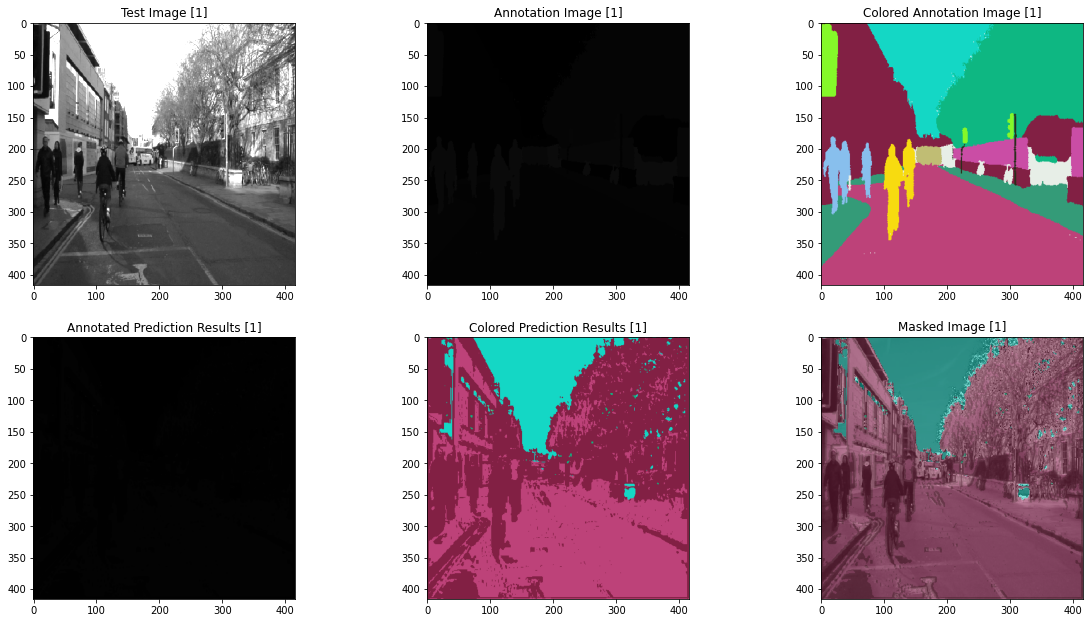

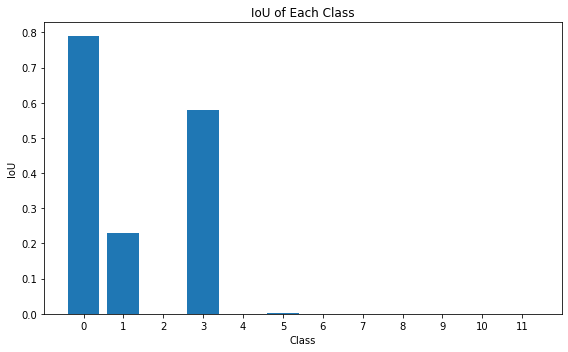

In [49]:
# testing the function
predict_annotation(test_x[0], test_y_cat[0], 1)

/tmp/ipykernel_1770788/3423435706.py:138: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))


saving figure to: /home/jovyan/Cityscape-image-segmentation-main/Prediction image/

IoU of Each Class:
IoU Class 0: 79.43%
IoU Class 1: 42.27%
IoU Class 2: 0.00%
IoU Class 3: 49.56%
IoU Class 4: 0.00%
IoU Class 5: 1.09%
IoU Class 6: 0.00%
IoU Class 7: 0.00%
IoU Class 8: 0.00%
IoU Class 9: 0.00%
IoU Class 10: 0.00%
IoU Class 11: 0.00%
Mean IoU: 14.36%


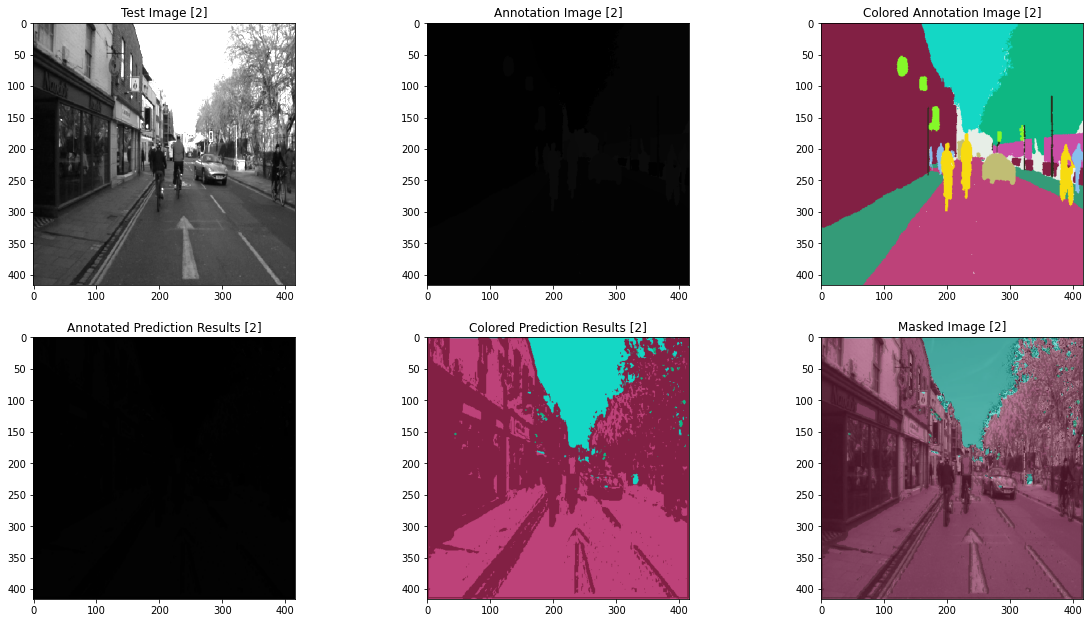

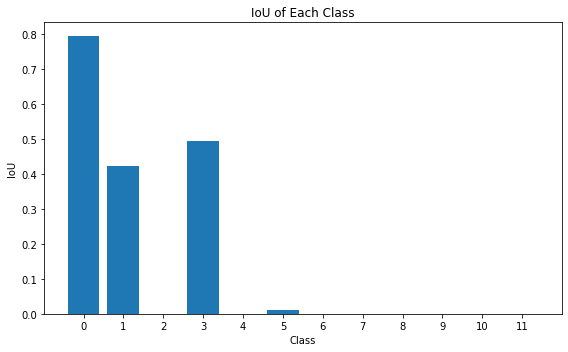

In [50]:
# testing the function
predict_annotation(test_x[1], test_y_cat[1], 2)

/tmp/ipykernel_1770788/3423435706.py:138: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))


saving figure to: /home/jovyan/Cityscape-image-segmentation-main/Prediction image/

IoU of Each Class:
IoU Class 0: 72.53%
IoU Class 1: 22.47%
IoU Class 2: 0.00%
IoU Class 3: 62.88%
IoU Class 4: 0.00%
IoU Class 5: 1.00%
IoU Class 6: 0.00%
IoU Class 7: 0.00%
IoU Class 8: 0.00%
IoU Class 9: 0.00%
IoU Class 10: 0.00%
IoU Class 11: 0.00%
Mean IoU: 13.24%


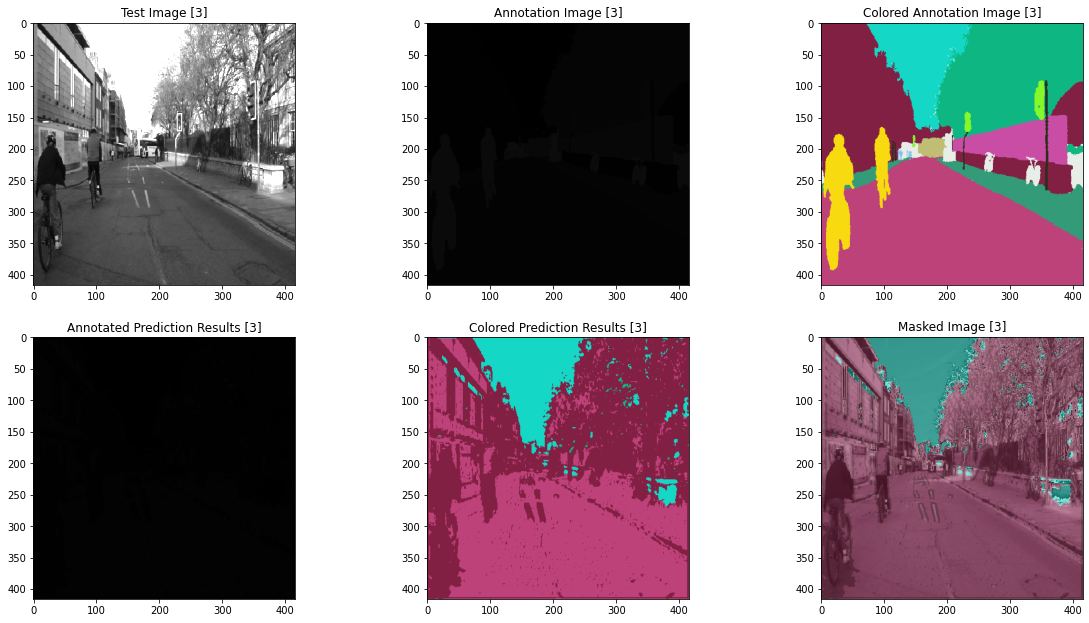

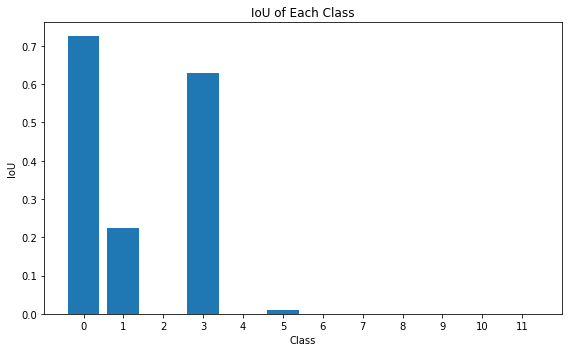

In [51]:
# testing the function
predict_annotation(test_x[2], test_y_cat[2], 3)